<H1>10,000 USD worth of INTR invested in the Omnipool for 4 months</H1>

In [50]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'INTR': {'usd price': price_list[0]['DOT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0,
            lrna_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool'
            )
        ),
        'LP': Agent(
            holdings={'INTR': 10000 / price_list[0]['DOT']},
            trade_strategy=invest_all('omnipool')
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = len(price_list)-1
# print(f'Running with {time_steps} time steps')
# events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

<h3>Effect of price change on LP returns.</h3> We'll simulate the returns for an LP over the course of four months under a variety of market conditions. We'll see that large price changes - even positive ones - are not best for LPs.

In [52]:
returns = []
intr_prices = []
price_events = []
plt.figure(figsize=(20, 5))
for i, scenario in enumerate(price_path):
    initial_state._evolve_function = historical_prices(scenario)
    random.seed(42)
    events = run.run(initial_state, time_steps)
    price_events.append(events[::200])
    returns.append([cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in price_events[i]])
    intr_prices.append(pu.get_datastream(price_events[i], asset='INTR'))
#     plt.plot(range(len(intr_prices[i])), intr_prices[i], color=colors[i])
#     plt.annotate(str(round(intr_prices[i][-1] * 10000, 2)), xy=(time_steps, intr_prices[-1]), xytext=(30,0), textcoords='offset points')
    
print('Trade volume per day as a fraction of TVL:', 
    sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
    / time_steps / 10000000 * 7200
)

Starting simulation...
Execution time: 80.89 seconds.
Starting simulation...
Execution time: 242.786 seconds.
Starting simulation...
Execution time: 190.85 seconds.
Starting simulation...
Execution time: 246.574 seconds.
Starting simulation...
Execution time: 1308.086 seconds.
Trade volume per day as a fraction of TVL: 0.08018896928960009


<Figure size 1440x360 with 0 Axes>

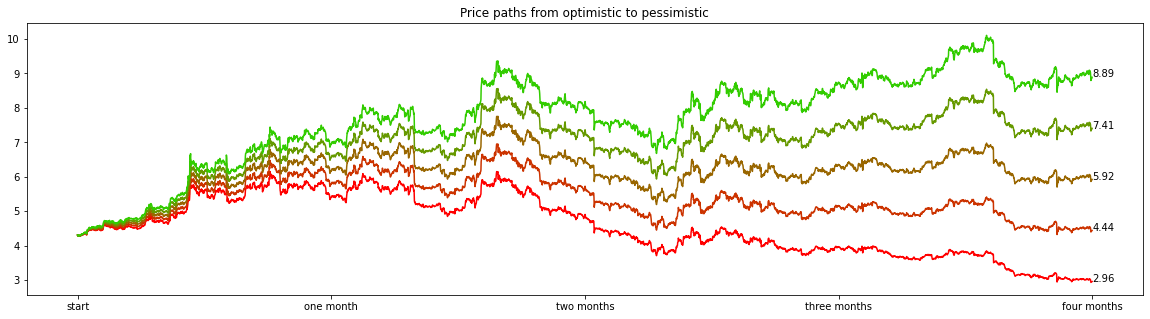

In [119]:
plt.figure(figsize=(20, 5))
plt.title("Price paths from optimistic to pessimistic")
graph_length = len(intr_prices[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

for i in range(len(intr_prices)):
    plt.plot(range(len(intr_prices[i])), intr_prices[i], color=colors[i])
    plt.annotate(str(round(intr_prices[i][-1], 2)), xy=(len(intr_prices[i]), intr_prices[i][-1]), xytext=(0,0), textcoords='offset points')


<h3>Results from the preceeding simulations.</h3> Note that due to impermanent loss, the middle price paths where there is little change from beginning to end fare best. Also note that it's the price change <i>relative to the rest of the assets in the pool</i> that matters... during this run, it's the middle path where the price of INTR most closely follows the gains experienced by the rest of the pool, and thus suffers the least impermanent loss.

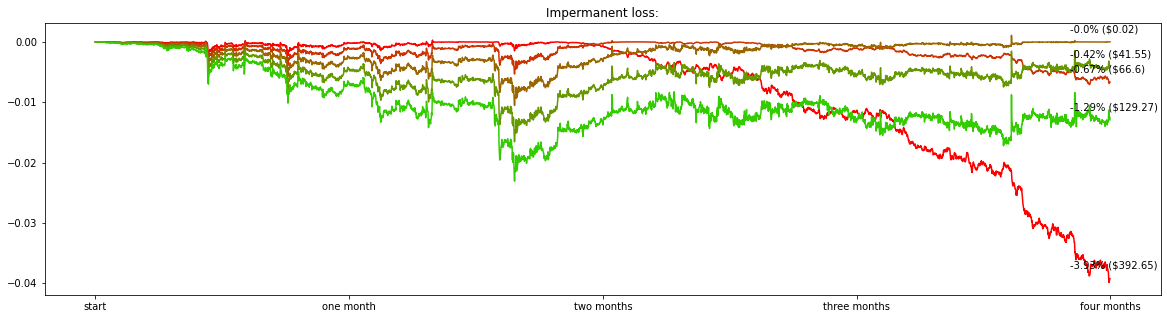

In [120]:
plt.figure(figsize=(20, 5))
plt.title('Impermanent loss:')
graph_length = len(returns[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

initial_holdings = initial_state.agents['LP'].holdings['INTR']
for i, scenario in enumerate(returns):
    il = [
        scenario[j] / initial_holdings / price_events[i][j].external_market['INTR'] - 1 
        for j, step in enumerate(scenario)
    ]
    plt.plot(
        range(len(scenario)), il, color=colors[i]
    )
    plt.annotate(
        f'{round(il[-1], 4) * 100}% (${abs(round(il[-1] * 10000, 2))})',
        xy=(len(scenario), il[-1]), xytext=(-40, 10), textcoords='offset points'
    )
# plt.plot([0, len(returns[0])], [baseline, baseline], color='black', linewidth=5)

In [111]:
volume_events = []
trade_volume = []
initial_state.pools['omnipool'].lrna_fee = 0.0005
initial_state.pools['omnipool'].asset_fee = 0.0025
initial_state._evolve_function = historical_prices(price_path[2])
for i in range(5):
    initial_state.agents['Trader'].trade_strategy=price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=60 * i + 10,
        price_sensitivity=20
    ) if i > 0 else price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=10,
        price_sensitivity=100
    )
    events = run.run(initial_state, time_steps)
    trade_volume.append((sum([sum([event.pools['omnipool'].volume_in[tkn] * event.external_market[tkn] for tkn in assets]) for event in events])
        / time_steps / 10000000 * 7200)
        # if i > 0 else 0
    )
    print('Trade volume per day as a fraction of TVL:', trade_volume[i])
    volume_events.append(events[::200])
    del events

Starting simulation...
Execution time: 374.128 seconds.
Trade volume per day as a fraction of TVL: 0.0029847507011692325
Starting simulation...
Execution time: 126.7 seconds.
Trade volume per day as a fraction of TVL: 0.02834404685173307
Starting simulation...
Execution time: 449.114 seconds.
Trade volume per day as a fraction of TVL: 0.052578614368143366
Starting simulation...
Execution time: 310.062 seconds.
Trade volume per day as a fraction of TVL: 0.07649126383224128
Starting simulation...
Execution time: 110.896 seconds.
Trade volume per day as a fraction of TVL: 0.1002759009244453


<H3>Effects of trade volume.</H3> Trade volume generates fees, which are the primary way of offsetting IL. We'll assume the middle price path for this example (minimum impermanent loss). Trade volume goes from 0.3% to 10% of TVL per day. (So far we have observed ~5% on average.) We also assume 0.3% total fees.
<br><br>
The bottom line is especially volatile because, with such low trade volume, the Omnipool price is unable to track the external market price as closely. 

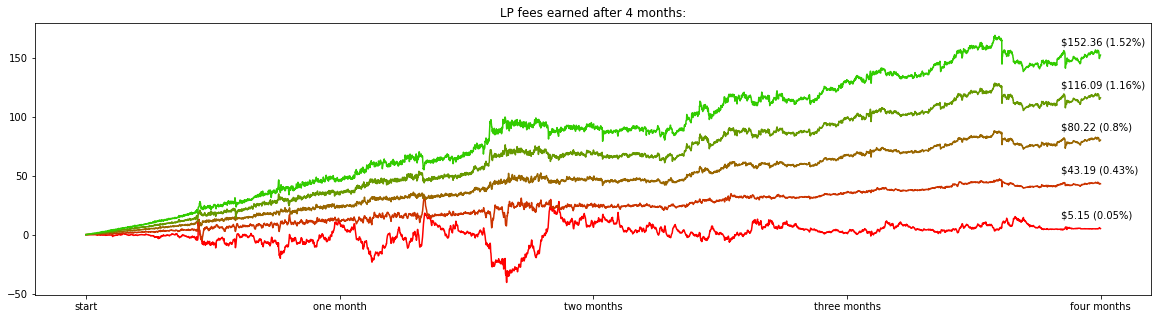

In [121]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after 4 months:')
graph_length = len(returns[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'one month', 'two months', 'three months', 'four months']
)

baseline = returns[2]  # this is the same price path, but with 0 fees
# [value_assets(event.external_market, initial_state.agents['LP'].holdings) for event in volume_events[0]]
# [0] * len(volume_events[0])
# [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in volume_events[0]]
volume_returns = [
    [
        cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline[i]
        for i, event in enumerate(events)
    ]
    for events in volume_events
]
for i, scenario in enumerate(volume_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, 10), textcoords='offset points'
    )